In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from SIFT import SIFT
from SIFT_tests import TestSIFT
from utils import load_image, PIL_resize, rgb2gray

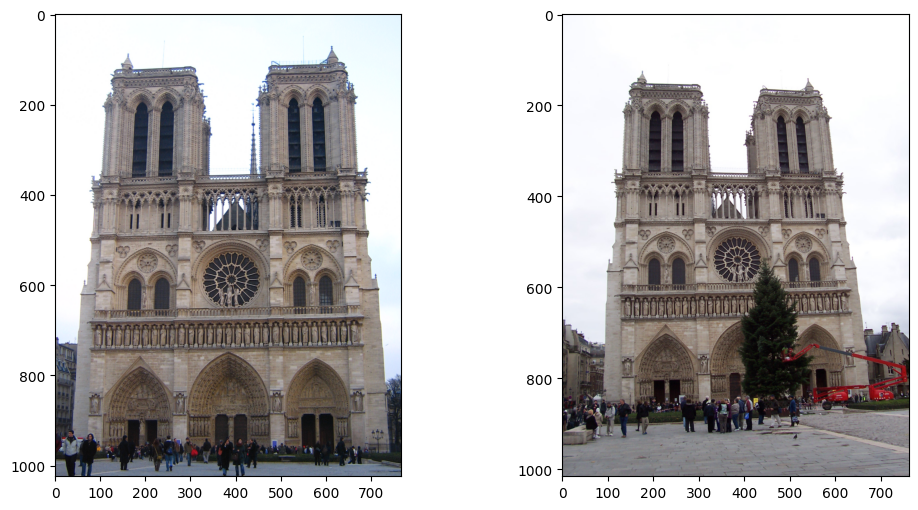

In [2]:
# Notre Dame
image1 = load_image('data/1a_notredame.jpg')
image2 = load_image('data/1b_notredame.jpg')
eval_file = '../ground_truth/notredame.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
# image1 = load_image('../data/2a_rushmore.jpg')
# image2 = load_image('../data/2b_rushmore.jpg')
# eval_file = '../ground_truth/rushmore.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
# image1 = load_image('../data/3a_gaudi.jpg')
# image2 = load_image('../data/3b_gaudi.jpg')
# eval_file = '../ground_truth/gaudi.pkl'

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))

image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

In [3]:
test_sift = TestSIFT()
test_sift.setUp()

In [4]:
# Run tests and visualize results
print("Testing compute_image_gradients...")
test_sift.test_compute_image_gradients(image1_bw)

Testing compute_image_gradients...


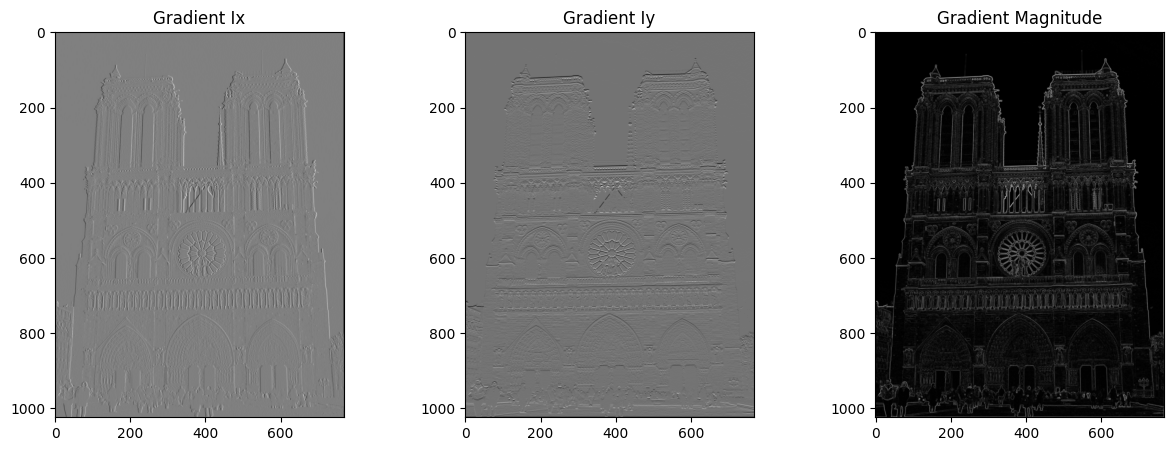

In [5]:
Ix, Iy = test_sift.sift._compute_image_gradients(image1_bw)
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)

# Visualize gradients and magnitude
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Gradient Ix")
plt.imshow(Ix, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Gradient Iy")
plt.imshow(Iy, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Gradient Magnitude")
plt.imshow(gradient_magnitudes, cmap='gray')
plt.show()

In [6]:
# 2. Testing generate_gaussian_kernel and visualizing the kernel
print("Testing generate_gaussian_kernel...")
ksize, sigma = 5, 1.5
test_sift.test_generate_gaussian_kernel(ksize, sigma)
kernel = test_sift.sift._generate_gaussian_kernel(ksize, sigma)

Testing generate_gaussian_kernel...


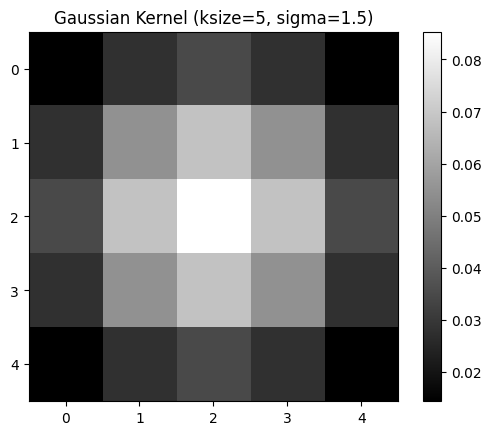

In [7]:
# Visualize Gaussian kernel
plt.figure()
plt.title(f"Gaussian Kernel (ksize={ksize}, sigma={sigma})")
plt.imshow(kernel, cmap='gray')
plt.colorbar()
plt.show()

In [8]:
# 3. Testing find_harris_interest_points and visualizing points on image
print("Testing find_harris_interest_points...")
x, y, confidences = test_sift.sift.find_harris_interest_points(image1_bw)

Testing find_harris_interest_points...


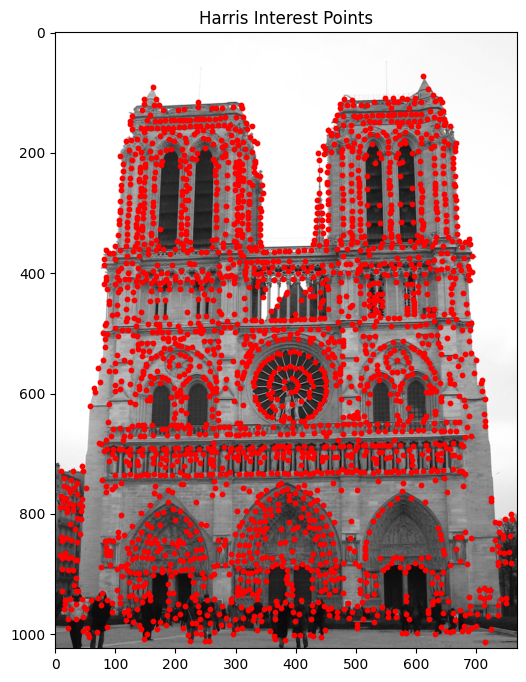

In [9]:
# Visualize interest points on the original image
plt.figure(figsize=(8, 8))
plt.imshow(image1_bw, cmap='gray')
plt.scatter(x, y, s=10, c='red', marker='o')
plt.title("Harris Interest Points")
plt.show()

In [10]:
# 4. Testing get_SIFT_descriptors and visualizing some descriptor patches
print("Testing get_SIFT_descriptors...")
test_sift.test_get_SIFT_descriptors(image1_bw, x, y)
descriptors = test_sift.sift.get_SIFT_descriptors(image1_bw, x, y, feature_width=16)

Testing get_SIFT_descriptors...


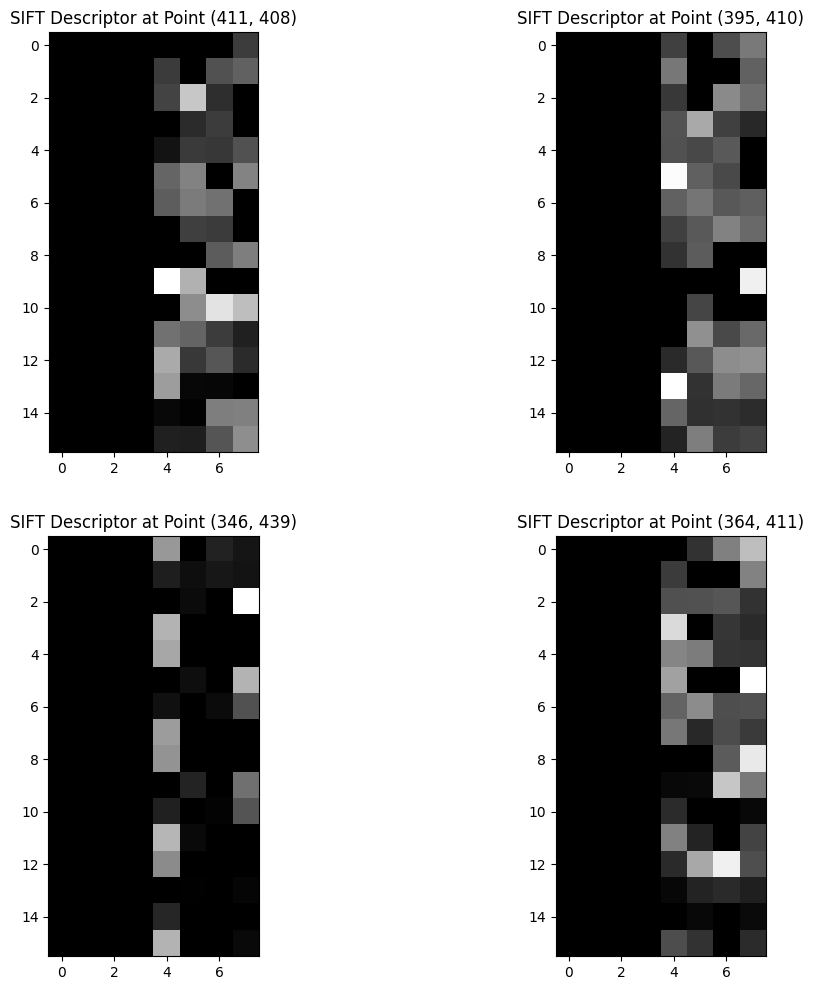

In [11]:
# Visualize a few SIFT descriptors as patches
plt.figure(figsize=(12, 12))
for i in range(4):  # Show 4 descriptors for brevity
    plt.subplot(2, 2, i + 1)
    descriptor_patch = descriptors[i].reshape((16, 8))  # Reshape for display purposes
    plt.imshow(descriptor_patch, cmap='gray')
    plt.title(f"SIFT Descriptor at Point ({x[i]}, {y[i]})")
plt.show()

In [12]:
from utils import show_correspondence_circles, show_correspondence_lines, save_image, match_features_ratio_test
X1, Y1, _ = test_sift.sift.find_harris_interest_points(image1_bw)
X2, Y2, _ = test_sift.sift.find_harris_interest_points(image2_bw)
image1_features = test_sift.sift.get_SIFT_descriptors(image1_bw, X1, Y1, feature_width=16)
image2_features = test_sift.sift.get_SIFT_descriptors(image2_bw, X2, Y2, feature_width=16)

# Match features between the two images
matches, confidences = match_features_ratio_test(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

113 matches from 2463 corners


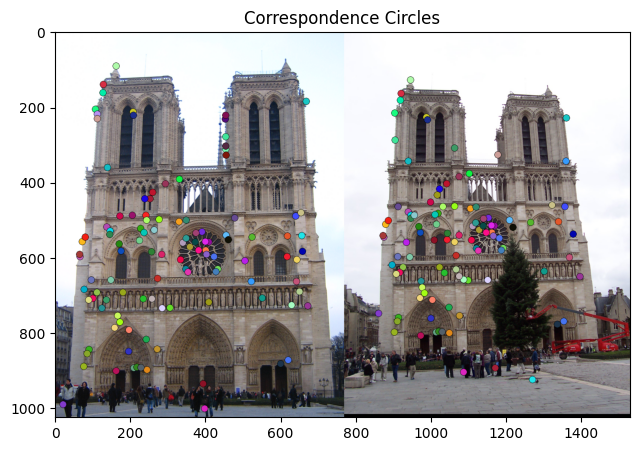

In [13]:
# Visualize the top matches
num_pts_to_visualize = min(200, len(matches))  # Limit to 200 or total matches if fewer
c1 = show_correspondence_circles(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)

# Display circles
plt.figure(figsize=(10, 5))
plt.title("Correspondence Circles")
plt.imshow(c1)
plt.show()

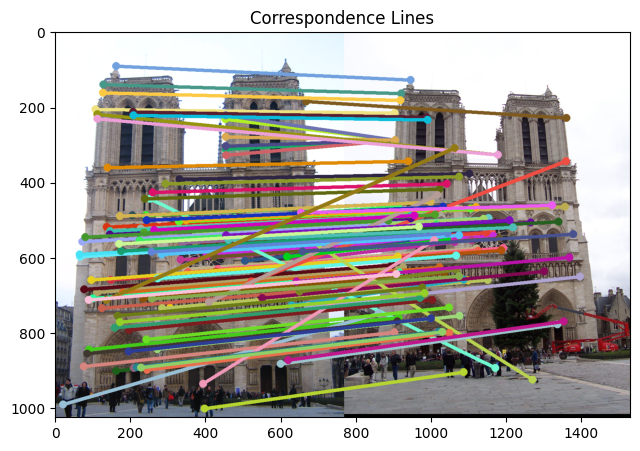

In [14]:
# Display correspondence lines
c2 = show_correspondence_lines(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)

plt.figure(figsize=(10, 5))
plt.title("Correspondence Lines")
plt.imshow(c2)
plt.show()

In [ ]:
# Get expected orientation from OpenCV
magnitudes = np.ones(100)
orientations = np.concatenate([
    np.full(50, np.pi / 4),    # 50 pixels with 45-degree orientation
    np.full(50, -np.pi / 4)    # 50 pixels with -45-degree orientation
])

# Convert orientations to the range [0, 360] for OpenCV (in degrees)
orientations_deg = np.degrees(orientations + np.pi) % 360  # Convert from radians to [0, 360]
magnitudes = magnitudes.astype(np.float32)

# Calculate histogram using OpenCV
hist = cv2.calcHist([orientations_deg.astype(np.float32)], [0], None, [36], [0, 360])

# Find the peak bin in the histogram
peak_bin = np.argmax(hist)
peak_angle_deg = (peak_bin + 0.5) * 10  # Each bin is 10 degrees wide

print("OpenCV Histogram Counts:", hist.ravel())
print("Peak Angle (Degrees):", peak_angle_deg)
print("Expected Peak Orientation (in radians):", np.radians(peak_angle_deg) - np.pi)


OpenCV Histogram Counts: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 50.  0.  0.  0.  0.
  0.  0.  0.  0. 50.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Peak Angle (Degrees): 135.0
Expected Peak Orientation (in radians): -0.7853981633974483


In [17]:
magnitudes = np.ones(100)
orientations = np.concatenate([
    np.full(50, np.pi / 4),    # 50 pixels with 45-degree orientation
    np.full(50, -np.pi / 4)    # 50 pixels with -45-degree orientation
])

dominant_orientation = test_sift.sift.compute_dominant_orientation(magnitudes, orientations)
print("Computed Dominant Orientation:", dominant_orientation)

Computed Dominant Orientation: -0.7853981633974483


In [16]:
import cv2
import numpy as np

# Example orientations and magnitudes (repeat synthetic data)
magnitudes = np.ones(100)
orientations = np.concatenate([
    np.full(50, np.pi / 4),    # 50 pixels with 45-degree orientation
    np.full(50, -np.pi / 4)    # 50 pixels with -45-degree orientation
])

# Convert orientations to the range [0, 360] for OpenCV (in degrees)
orientations_deg = np.degrees(orientations + np.pi) % 360  # Convert from radians to [0, 360]
magnitudes = magnitudes.astype(np.float32)

# Calculate histogram using OpenCV
hist = cv2.calcHist([orientations_deg.astype(np.float32)], [0], None, [36], [0, 360])

# Find the peak bin in the histogram
peak_bin = np.argmax(hist)
peak_angle_deg = (peak_bin + 0.5) * 10  # Each bin is 10 degrees wide

print("OpenCV Histogram Counts:", hist.ravel())
print("Peak Angle (Degrees):", peak_angle_deg)
print("Expected Peak Orientation (in radians):", np.radians(peak_angle_deg) - np.pi)


OpenCV Histogram Counts: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 50.  0.  0.  0.  0.
  0.  0.  0.  0. 50.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Peak Angle (Degrees): 135.0
Expected Peak Orientation (in radians): -0.7853981633974483
